In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [42]:
df = pd.read_csv('MNCAATourneyCompactResults.csv')
kpom = pd.read_csv('kpom (1).csv')
df.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [142]:
kpom = kpom.rename(columns = {'Rk':'KPomRk'})
kpom = kpom.drop(['AdjO'], axis=1)

kpom.head()

,Unnamed: 0,KPomRk,Team,TeamID
0,0,1,Gonzaga,1211.0
1,1,2,Michigan,1276.0
2,2,3,Illinois,1228.0
3,3,4,Iowa,1234.0
4,4,5,Baylor,1124.0


In [44]:
#merge seeds and box score with compact results 
Seeds = pd.read_csv('MNCAATourneySeeds.csv')
BoxScore = pd.read_csv('MNCAATourneyDetailedResults.csv')
df = df.merge(Seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'WSeed'})
df = df.merge(Seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'LSeed'})

df = df.merge(BoxScore, how='left', left_on=['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT'], right_on=['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc', 'NumOT'])

#seed to float
df['WSeed'] = df['WSeed'].str.replace(r'[^0-9]', '').astype('float')
df['LSeed'] = df['LSeed'].str.replace(r'[^0-9]', '').astype('float')

#add point differential 
NewCol = df["WScore"] - df["LScore"]
df.insert(0, 'PointDiff', NewCol)


df.tail()

,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2246,6,2019,146,1120,77,1246,71,N,1,5.0,...,21.0,12.0,21.0,11.0,30.0,14.0,14.0,5.0,5.0,19.0
2247,1,2019,146,1277,68,1181,67,N,0,2.0,...,21.0,8.0,13.0,13.0,29.0,14.0,17.0,4.0,9.0,9.0
2248,10,2019,152,1403,61,1277,51,N,0,3.0,...,24.0,14.0,18.0,8.0,28.0,6.0,11.0,1.0,2.0,15.0
2249,1,2019,152,1438,63,1120,62,N,0,1.0,...,31.0,11.0,14.0,9.0,24.0,9.0,5.0,3.0,3.0,12.0
2250,8,2019,154,1438,85,1403,77,N,1,1.0,...,30.0,13.0,15.0,9.0,23.0,9.0,8.0,6.0,3.0,18.0


In [45]:
df["PointDiff"] = df["PointDiff"].astype(float)

In [46]:
#add seed differential 
NewCol1 = df["WSeed"] - df["LSeed"]
df.insert(loc=0, column='SeedDiff', value=NewCol1)

df.tail()

,SeedDiff,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
2246,3.0,6.0,2019,146,1120,77,1246,71,N,1,...,21.0,12.0,21.0,11.0,30.0,14.0,14.0,5.0,5.0,19.0
2247,1.0,1.0,2019,146,1277,68,1181,67,N,0,...,21.0,8.0,13.0,13.0,29.0,14.0,17.0,4.0,9.0,9.0
2248,1.0,10.0,2019,152,1403,61,1277,51,N,0,...,24.0,14.0,18.0,8.0,28.0,6.0,11.0,1.0,2.0,15.0
2249,-4.0,1.0,2019,152,1438,63,1120,62,N,0,...,31.0,11.0,14.0,9.0,24.0,9.0,5.0,3.0,3.0,12.0
2250,-2.0,8.0,2019,154,1438,85,1403,77,N,1,...,30.0,13.0,15.0,9.0,23.0,9.0,8.0,6.0,3.0,18.0


In [47]:
#Points
df['WPts'] = df.apply(lambda x: 2*x.WFGM + x.WFGM3 + x.WFTM, axis=1)
df['LPts'] = df.apply(lambda x: 2*x.LFGM + x.LFGM3 + x.LFTM, axis=1)

#Possessions for each team
#This is the generally accepted best method for calculating possessions
wPos = df.apply(lambda x: 0.96*(x.WFGA + x.WTO + 0.44*x.WFTA - x.WOR), axis=1)
lPos = df.apply(lambda x: 0.96*(x.LFGA + x.LTO + 0.44*x.LFTA - x.LOR), axis=1)

#average possessions for good estimate
df['Pos'] = (wPos+lPos)/2

#Offensive efficiency = 100 x (Points / Possessions)
df['WOffRtg'] = df.apply(lambda x: 100 * (x.WPts / x.Pos), axis=1)
df['LOffRtg'] = df.apply(lambda x: 100 * (x.LPts / x.Pos), axis=1)
#Defensive efficiency = 100 x (Opponent points / Opponent possessions)
df['WDefRtg'] = df.LOffRtg
df['LDefRtg'] = df.WOffRtg
#Net Rating = Off.Rtg - Def.Rtg
df['WNetRtg'] = df.apply(lambda x:(x.WOffRtg - x.WDefRtg), axis=1)
df['LNetRtg'] = df.apply(lambda x:(x.LOffRtg - x.LDefRtg), axis=1)

#Field Goal Percantage
df['WFG%'] = df.apply(lambda x: (x.WFGM / x.WFGA), axis=1)
df['LFG%'] = df.apply(lambda x: (x.LFGM / x.LFGA), axis=1)

#True Shooting Percentage = Points/2(Field Goal Attempts + .44(Free Throw Attempts))
df['WTS%'] = df.apply(lambda x: 100*((x.WFGM3 + 2*x.WFGM + x.WFTM) / (2*(x.WFGA + .44*x.WFTA))), axis=1)
df['LTS%'] = df.apply(lambda x: 100*((x.LFGM3 + 2*x.LFGM + x.WFTM) / (2*(x.LFGA + .44*x.LFTA))), axis=1)

#Turnover to assist ratio
df['WTOAst'] = df.apply(lambda x: (x.WTO) / (x.WAst), axis=1)
df['LTOAst'] = df.apply(lambda x: (x.LTO) / (x.LAst), axis=1)

#Effective Field Goal Percentage: (FGM + 0.5 * 3PM) / FGA
df['WeFGp'] = df.apply(lambda x: 100*((x.WFGM + .5*x.WFGM3) / (x.WFGA)), axis=1)
df['LeFGp'] = df.apply(lambda x: 100*((x.LFGM + .5*x.LFGM3) / (x.LFGA)), axis=1)

#Free Throw Percentage
df['WFTp'] = df.apply(lambda x: 100*(x.WFTM / (x.WFTA)), axis=1)
df['LFTp'] = df.apply(lambda x: 100*(x.LFTM / (x.LFTA)), axis=1)

#Free Throw Rate
df['WFTr'] = df.apply(lambda x: 100*(x.WFTA / (x.WFGA)), axis=1)
df['LFTr'] = df.apply(lambda x: 100*(x.LFTA / (x.LFGA)), axis=1)

#Turnover Percentage
df['WTOp'] = df.apply(lambda x: 100*(x.WTO / (x.WFGA + .44*x.WFTA + x.WTO)), axis=1)
df['LTOp'] = df.apply(lambda x: 100*(x.LTO / (x.LFGA + .44*x.LFTA + x.LTO)), axis=1)

#3 Point Field Goal Percantage
df['WFG3p'] = df.apply(lambda x: (x.WFGM3 / x.WFGA3), axis=1)
df['LFG3p'] = df.apply(lambda x: (x.LFGM3 / x.LFGA3), axis=1)

#PIE %
wtemp = df.apply(lambda x: x.WPts + x.WFGM + x.WFTM - x.WFGA - x.WFTA + x.WDR + .5*x.WOR + x.WAst + x.WStl + .5*x.WBlk - x.WPF - x.WTO, axis=1)
ltemp = df.apply(lambda x: x.LPts + x.LFGM + x.LFTM - x.LFGA - x.LFTA + x.LDR + .5*x.LOR + x.LAst + x.LStl + .5*x.LBlk - x.LPF - x.LTO, axis=1)
df['WPIE'] = wtemp/(wtemp + ltemp)
df['LPIE'] = ltemp/(wtemp + ltemp)

#Rebound Percentage
df['WDRp'] = df.apply(lambda x: 100*(x.WDR / x.WDR + x.WOR), axis=1)
df['WORp'] = df.apply(lambda x: 100*(x.WOR / x.WDR + x.WOR), axis=1)
df['LDRp'] = df.apply(lambda x: 100*(x.LDR / x.LDR + x.LOR), axis=1)
df['LORp'] = df.apply(lambda x: 100*(x.LOR / x.LDR + x.LOR), axis=1)

#Total Rebounds
df['WTReb'] = df.apply(lambda x: x.WDR + x.WOR, axis=1)
df['LTReb'] = df.apply(lambda x: x.LDR + x.LOR, axis=1)

df = df.drop(['WFTr', 'LFTr', 'WDRp', 'WORp', 'LDRp', 'LORp'], axis=1)

df.tail()


,SeedDiff,PointDiff,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,...,WFTp,LFTp,WTOp,LTOp,WFG3p,LFG3p,WPIE,LPIE,WTReb,LTReb
2246,3.0,6.0,2019,146,1120,77,1246,71,N,1,...,75.000000,57.142857,10.643330,16.619183,0.304348,0.238095,0.511737,0.488263,37.0,41.0
2247,1.0,1.0,2019,146,1277,68,1181,67,N,0,...,33.333333,61.538462,8.789553,21.324636,0.315789,0.333333,0.496000,0.504000,31.0,42.0
2248,1.0,10.0,2019,152,1403,61,1277,51,N,0,...,61.538462,77.777778,10.985562,16.686893,0.391304,0.291667,0.605442,0.394558,30.0,36.0
2249,-4.0,1.0,2019,152,1438,63,1120,62,N,0,...,50.000000,78.571429,12.445551,7.557437,0.368421,0.290323,0.545455,0.454545,31.0,33.0
2250,-2.0,8.0,2019,154,1438,85,1403,77,N,1,...,86.956522,86.666667,13.729406,10.309278,0.458333,0.333333,0.577778,0.422222,39.0,32.0


In [48]:
print(df.columns.values)
print(df.dtypes)

['SeedDiff' 'PointDiff' 'Season' 'DayNum' 'WTeamID' 'WScore' 'LTeamID'
 'LScore' 'WLoc' 'NumOT' 'WSeed' 'LSeed' 'WFGM' 'WFGA' 'WFGM3' 'WFGA3'
 'WFTM' 'WFTA' 'WOR' 'WDR' 'WAst' 'WTO' 'WStl' 'WBlk' 'WPF' 'LFGM' 'LFGA'
 'LFGM3' 'LFGA3' 'LFTM' 'LFTA' 'LOR' 'LDR' 'LAst' 'LTO' 'LStl' 'LBlk'
 'LPF' 'WPts' 'LPts' 'Pos' 'WOffRtg' 'LOffRtg' 'WDefRtg' 'LDefRtg'
 'WNetRtg' 'LNetRtg' 'WFG%' 'LFG%' 'WTS%' 'LTS%' 'WTOAst' 'LTOAst' 'WeFGp'
 'LeFGp' 'WFTp' 'LFTp' 'WTOp' 'LTOp' 'WFG3p' 'LFG3p' 'WPIE' 'LPIE' 'WTReb'
 'LTReb']
SeedDiff     float64
PointDiff    float64
Season         int64
DayNum         int64
WTeamID        int64
              ...   
LFG3p        float64
WPIE         float64
LPIE         float64
WTReb        float64
LTReb        float64
Length: 65, dtype: object


In [16]:
#Below, I created a correlation matric for all of the variables. 
# I had trouble isolating only the PointDiff row, but that's really the only one I care about. 
#Takeaways: OffRtg, DefRtg, NetRtg, FG%, TS%, SeedDiff, WScore, WDR, and WAst all have strongest correlation with PointDif
#note that although NetRtg has a correlation of .99/-.99, that's expected since it measures points scored/ points allowed 


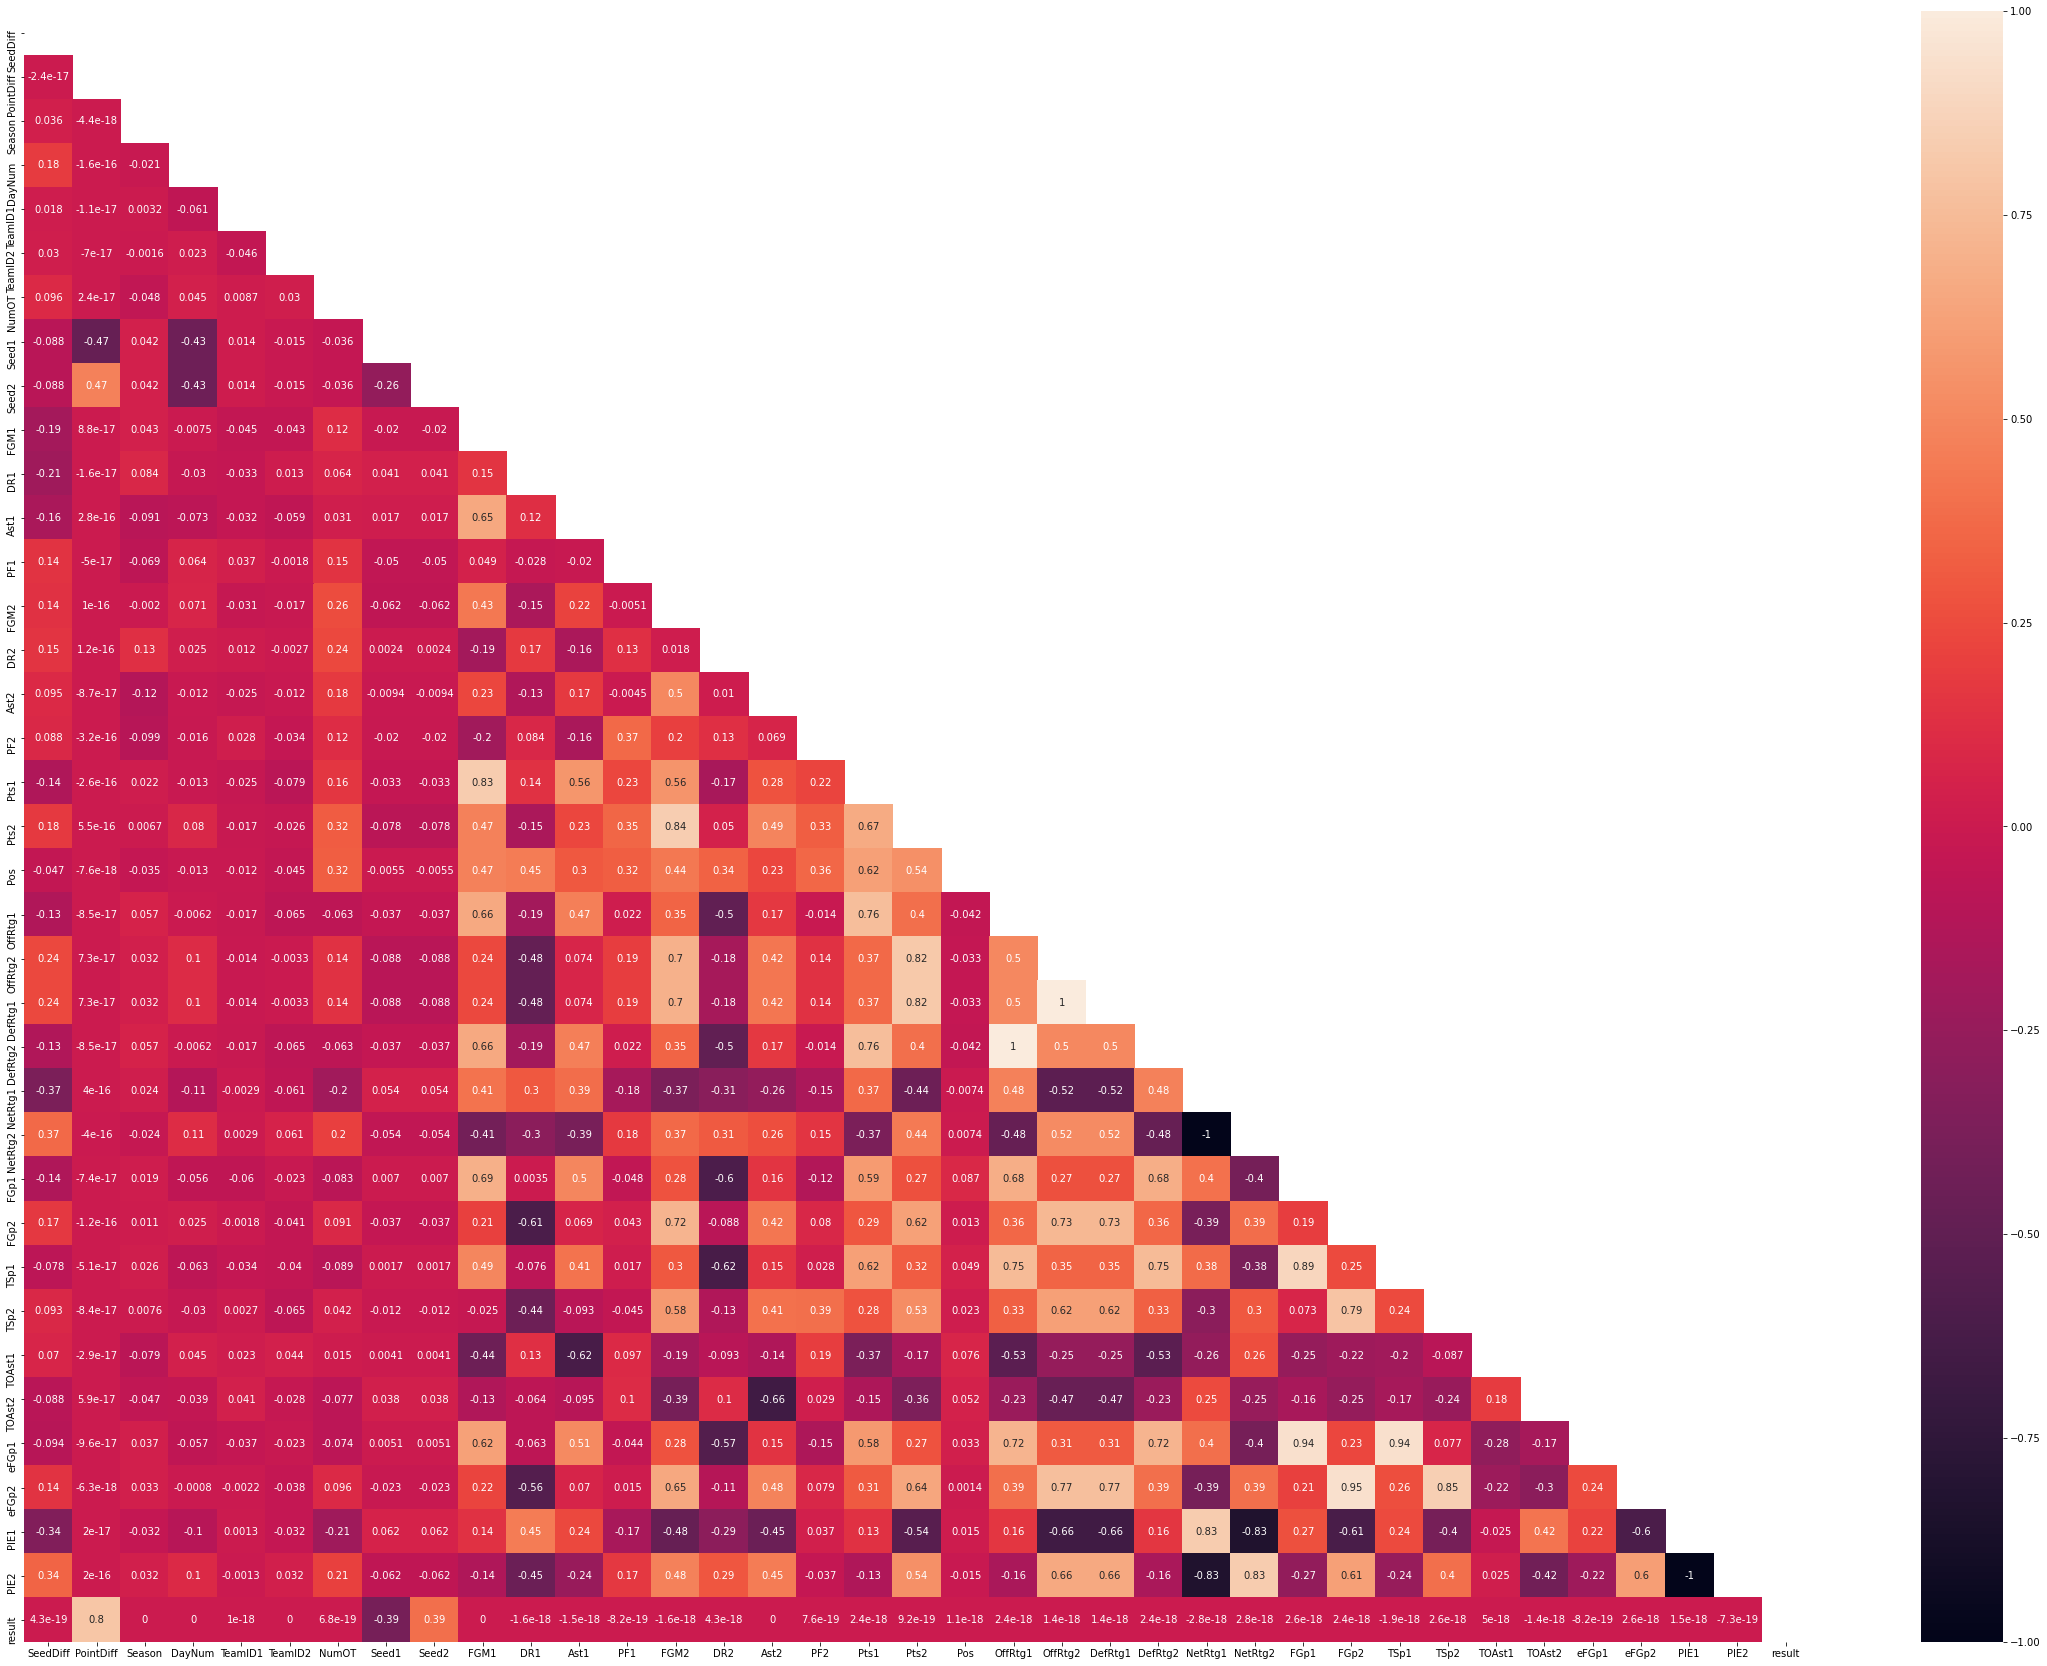

In [126]:
corrMatrix = df_final[df_final.columns[:]].corr()
fig, ax = plt.subplots(figsize=(40,30))
matrix = np.triu(df.corr())
sns.heatmap(corrMatrix, annot=True, mask=matrix)
plt.show()

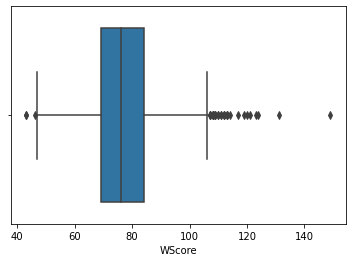

In [19]:
sns.boxplot(x = "WScore", data = df)

In [90]:
df.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WFGM': 'FGM1', 'WFGA': 'FGA1', 'WFGM3': 'FGM31', 'WFGA3': 'FGA31',
 'WFTM': 'FTM1', 'WFTA': 'FTA1', 'WOR': 'OR1', 'WDR': 'DR1', 'WAst': 'Ast1', 'WTO': 'TO1', 'WStl': 'Stl1', 'WBlk': 'Blk1', 'WPF': 'PF1', 'LFGM': 'FGM2', 'LFGA': 'FGA2',
 'LFGM3': 'FGM32', 'LFGA3': 'FGA32', 'LFTM': 'FTM2', 'LFTA': 'FTA2', 'LOR': 'OR2', 'LDR': 'DR2', 'LAst': 'Ast2', 'LTO': 'TO2', 'LStl': 'Stl2', 'LBlk': 'Blk2',
 'LPF': 'PF2', 'WPts': 'Pts1', 'LPts': 'Pts2', 'WOffRtg': 'OffRtg1', 'LOffRtg': 'OffRtg2', 'WDefRtg': 'DefRtg1', 'LDefRtg': 'DefRtg2',
 'WNetRtg': 'NetRtg1', 'LNetRtg': 'NetRtg2', 'WFG%': 'FGp1', 'LFG%': 'FGp2', 'WTS%': 'TSp1', 'LTS%': 'TSp2', 'WTOAst': 'TOAst1', 'LTOAst': 'TOAst2', 'WeFGp': 'eFGp1',
 'LeFGp': 'eFGp2', 'WFTp': 'FTp1', 'LFTp': 'FTp2', 'WTOp': 'TOp1', 'LTOp': 'TOp2', 'WFG3p': 'FG3p1', 'LFG3p': 'FG3p2', 'WPIE': 'PIE1', 'LPIE': 'PIE2', 'WTReb': 'TReb1',
 'LTReb': 'TReb2'}, inplace=True)


#create new df with same contents as original but flipped
df_2 = df.copy()
df_2['Seed1'] = df['Seed2']
df_2['Seed2'] = df['Seed1']
df_2.rename(columns={'FGM1': 'tmp2', 'FGM2': 'FGM1','FGA1': 'tmp3', 'FGA2': 'FGA1', 'FGM31': 'tmp4', 'FGM32': 'FGM31', 'FGA31': 'tmp5', 'FGM2': 'FGM1',}, inplace=True)
df_2.rename(columns={'tmp1': 'Seed2', 'Seed2': 'Seed1'}, inplace=True)

#df.drop(['FG3p1', 'FG3p2', 'TReb1', 'TReb2', 'WScore', 'LScore'], axis=1, inplace=True)
#df_2.drop(['FG3p1', 'FG3p2', 'TReb1', 'TReb2', 'WScore', 'LScore'], axis=1, inplace=True)

#df.rename(columns={'WTeamID': 'TeamID1', 'LTeamID': 'TeamID2'}, inplace=True)
#df_2.rename(columns={'WTeamID': 'TeamID2', 'LTeamID': 'TeamID1'}, inplace=True)


df_2['PointDiff'] = -1*df_2['PointDiff']
df_2.rename(columns = {'FGM1':'tmp1', 'DR1':'tmp2', 'Ast1':'tmp3', 'PF1':'tmp4', 'FGM2':'tmp5', 'DR2':'tmp6', 'Ast2':'tmp7',
 'PF2':'tmp8', 'Pts1':'tmp9', 'Pts2':'tmp10', 'OffRtg1':'tmp11', 'OffRtg2':'tmp12', 'DefRtg1':'tmp13', 'DefRtg2':'tmp14',
 'NetRtg1':'tmp15', 'NetRtg2':'tmp16', 'FGp1':'tmp17', 'FGp2':'tmp18', 'TSp1':'tmp19', 'TSp2':'tmp20', 'TOAst1':'tmp21', 'TOAst2':'tmp22', 'eFGp1':'tmp23',
 'eFGp2':'tmp24', 'PIE1':'tmp25', 'PIE2':'tmp26',}, inplace=True)
df_2.rename(columns = {'tmp1': 'FGM2', 'tmp2': 'DR2', 'tmp3': 'Ast2', 'tmp4': 'PF2', 'tmp5': 'FGM1', 'tmp6': 'DR1', 'tmp7': 'Ast1', 'tmp8': 'PF1', 'tmp9': 'Pts2', 'tmp10': 'Pts1', 'tmp11': 'OffRtg2', 'tmp12': 'OffRtg1', 'tmp13': 'DefRtg2', 'tmp14': 'DefRtg1', 'tmp15': 'NetRtg2', 'tmp16': 'NetRtg1', 'tmp17': 'FGp2', 'tmp18': 'FGp1', 'tmp19': 'TSp2', 'tmp20': 'TSp1', 'tmp21': 'TOAst2', 'tmp22': 'TOAst1', 'tmp23': 'eFGp2', 'tmp24': 'eFGp1', 'tmp25': 'PIE2', 'tmp26': 'PIE1'}, inplace=True)
df_2.rename(columns = {'Seed2': 'Seed1'}, inplace=True)


print(df.columns.values)
print(df_2.columns.values)

        



['SeedDiff' 'PointDiff' 'Season' 'DayNum' 'TeamID1' 'TeamID2' 'WLoc'
 'NumOT' 'Seed1' 'Seed2' 'FGM1' 'DR1' 'Ast1' 'PF1' 'FGM2' 'DR2' 'Ast2'
 'PF2' 'Pts1' 'Pts2' 'Pos' 'OffRtg1' 'OffRtg2' 'DefRtg1' 'DefRtg2'
 'NetRtg1' 'NetRtg2' 'FGp1' 'FGp2' 'TSp1' 'TSp2' 'TOAst1' 'TOAst2' 'eFGp1'
 'eFGp2' 'PIE1' 'PIE2' 'result']
['SeedDiff' 'PointDiff' 'Season' 'DayNum' 'TeamID1' 'TeamID2' 'WLoc'
 'NumOT' 'Seed1' 'Seed1' 'DR2' 'DR2' 'Ast2' 'PF2' 'FGM2' 'DR1' 'Ast1'
 'PF1' 'Pts2' 'Pts1' 'Pos' 'OffRtg2' 'OffRtg1' 'DefRtg2' 'DefRtg1'
 'NetRtg2' 'NetRtg1' 'FGp2' 'FGp1' 'TSp2' 'TSp1' 'TOAst2' 'TOAst1' 'eFGp2'
 'eFGp1' 'PIE2' 'PIE1' 'result']


In [143]:
#rename and change columns of second data frame to be opposite of first
df_2.columns = ['SeedDiff', 'PointDiff', 'Season', 'DayNum', 'TeamID1', 'TeamID2', 'WLoc',
 'NumOT', 'Seed2', 'Seed1', 'FGM2', 'DR2', 'Ast2', 'PF2', 'FGM1', 'DR1', 'Ast1',
 'PF1', 'Pts2', 'Pts1', 'Pos', 'OffRtg2', 'OffRtg1', 'DefRtg2', 'DefRtg1',
 'NetRtg2', 'NetRtg1', 'FGp2', 'FGp1', 'TSp2', 'TSp1', 'TOAst2', 'TOAst1', 'eFGp2',
 'eFGp1', 'PIE2', 'PIE1', 'result']

df_2 = df_2[['SeedDiff', 'PointDiff', 'Season', 'DayNum', 'TeamID1', 'TeamID2', 'WLoc',
 'NumOT', 'Seed1', 'Seed2', 'FGM1', 'DR1', 'Ast1', 'PF1', 'FGM2', 'DR2', 'Ast2',
 'PF2', 'Pts1', 'Pts2', 'Pos', 'OffRtg1', 'OffRtg2', 'DefRtg1', 'DefRtg2',
 'NetRtg1', 'NetRtg2', 'FGp1', 'FGp2', 'TSp1', 'TSp2', 'TOAst1', 'TOAst2', 'eFGp1',
 'eFGp2', 'PIE1', 'PIE2', 'result']]


print(df_2.columns.values)
df_2['result'] = 0



['SeedDiff' 'PointDiff' 'Season' 'DayNum' 'TeamID1' 'TeamID2' 'WLoc'
 'NumOT' 'Seed1' 'Seed2' 'FGM1' 'DR1' 'Ast1' 'PF1' 'FGM2' 'DR2' 'Ast2'
 'PF2' 'Pts1' 'Pts2' 'Pos' 'OffRtg1' 'OffRtg2' 'DefRtg1' 'DefRtg2'
 'NetRtg1' 'NetRtg2' 'FGp1' 'FGp2' 'TSp1' 'TSp2' 'TOAst1' 'TOAst2' 'eFGp1'
 'eFGp2' 'PIE1' 'PIE2' 'result']


In [165]:
#concatenate two dataframes
#df['result'] = 1
#df_2['result'] = 0
df_final = pd.concat([df, df_2], ignore_index=True)
df_final = df_final.dropna()
df_final.drop(['WLoc'], inplace=True, axis=1)
#merge kenpom data
df_final = df_final.merge(kpom, how='left', left_on=['TeamID1'], right_on=['TeamID']).drop('TeamID', axis=1)
df_final.drop(['Unnamed: 0_x', 'KPomRk_x', 'Team_x', 'Unnamed: 0_y', 'KPomRk_y', 'Team_y', 'Unnamed: 0', 'Team'], axis =1, inplace=True)

print(df_final)


      SeedDiff  PointDiff  Season  DayNum  TeamID1  TeamID2  NumOT  Seed1  \
0          0.0        8.0    2003     134     1421     1411      1   16.0   
1        -15.0       29.0    2003     136     1112     1436      0    1.0   
2          3.0       13.0    2003     136     1113     1272      0   10.0   
3         -1.0        2.0    2003     136     1143     1301      1    8.0   
4         -7.0        5.0    2003     136     1163     1140      0    5.0   
...        ...        ...     ...     ...      ...      ...    ...    ...   
1074       3.0        6.0    2019     146     1120     1246      1    5.0   
1075       1.0        1.0    2019     146     1277     1181      0    2.0   
1076       1.0       10.0    2019     152     1403     1277      0    3.0   
1077      -4.0        1.0    2019     152     1438     1120      0    1.0   
1078      -2.0        8.0    2019     154     1438     1403      1    1.0   

      Seed2  FGM1  ...       TSp1       TSp2    TOAst1    TOAst2      eFGp1

In [166]:
print(df_final)


      SeedDiff  PointDiff  Season  DayNum  TeamID1  TeamID2  NumOT  Seed1  \
0          0.0        8.0    2003     134     1421     1411      1   16.0   
1        -15.0       29.0    2003     136     1112     1436      0    1.0   
2          3.0       13.0    2003     136     1113     1272      0   10.0   
3         -1.0        2.0    2003     136     1143     1301      1    8.0   
4         -7.0        5.0    2003     136     1163     1140      0    5.0   
...        ...        ...     ...     ...      ...      ...    ...    ...   
1074       3.0        6.0    2019     146     1120     1246      1    5.0   
1075       1.0        1.0    2019     146     1277     1181      0    2.0   
1076       1.0       10.0    2019     152     1403     1277      0    3.0   
1077      -4.0        1.0    2019     152     1438     1120      0    1.0   
1078      -2.0        8.0    2019     154     1438     1403      1    1.0   

      Seed2  FGM1  ...       TSp1       TSp2    TOAst1    TOAst2      eFGp1

In [168]:
#set variables
y = df_final['result'].values
X = df_final.drop('result', axis=1).values

#hyperparamaterize C
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier
logreg = LogisticRegression(max_iter=100000)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 41)

# Instantiate the GridSearchCV object
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))


C:\Users\jacob\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1372, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\jacob\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Tr

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [135]:
rfe = RFE(logreg, 15)
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)
print(df_final.columns)

C:\Users\jacob\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[ True  True False False False False  True  True  True  True False False
 False  True  True False  True  True False  True False False False False
 False False False False  True  True False False  True  True False False]
[ 1  1 13  8 18 19  1  1  1  1  3  5  2  1  1 16  1  1 21  1 10 11 14 12
  7  9 17 15  1  1  4  6  1  1 20 22]
Index(['SeedDiff', 'PointDiff', 'Season', 'DayNum', 'TeamID1', 'TeamID2',
       'NumOT', 'Seed1', 'Seed2', 'FGM1', 'DR1', 'Ast1', 'PF1', 'FGM2', 'DR2',
       'Ast2', 'PF2', 'Pts1', 'Pts2', 'Pos', 'OffRtg1', 'OffRtg2', 'DefRtg1',
       'DefRtg2', 'NetRtg1', 'NetRtg2', 'FGp1', 'FGp2', 'TSp1', 'TSp2',
       'TOAst1', 'TOAst2', 'eFGp1', 'eFGp2', 'PIE1', 'PIE2', 'result'],
      dtype='object')


In [131]:
logreg = LogisticRegression(max_iter=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(logreg.score(X_test, y_test))

0.47832585949177875


C:\Users\jacob\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [132]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
